In [22]:
import pandas as pd
import numpy as np
from find import *
df = pd.read_csv('match_event.csv')
# Only consider events that are successful
df = searchDF(df, [('is_success', 't')])
df['eventsec'] = df['eventsec'].apply(lambda x: round(x))
df.fillna({'eventname':'None'}, inplace=True)
df.fillna({'action':'None'}, inplace=True)
df.fillna({'modifier':'None'}, inplace=True)
df = df.drop(columns=['is_success'])

match_period = df['matchperiod'].unique()
match_map = {'1H': 1,
             '2H': 2}

event_df = pd.DataFrame(columns=['id', 'event'])
events = df['eventname'].unique()
events = np.sort(events)
event_map = {events[i]: i for i in range(len(events))}
event_df['eventname'] = events
event_df['id'] = event_map.values()
event_df.to_csv('fkeys/event.csv', index=False)

action_df = pd.DataFrame(columns=['id', 'action'])
actions = df['action'].unique()
actions = np.sort(actions)
action_map = {actions[i]: i for i in range(len(actions))}
action_df['action'] = actions
action_df['id'] = action_map.values()
action_df.to_csv('fkeys/action.csv', index=False)

modifier_df = pd.DataFrame(columns=['id', 'modifier'])
modifiers = df['modifier'].unique()
modifiers = np.sort(modifiers)
modifier_map = {modifiers[i]: i for i in range(len(modifiers))}
modifier_df['modifier'] = modifiers
modifier_df['id'] = modifier_map.values()
modifier_df.to_csv('fkeys/modifier.csv', index=False)

df['matchperiod'] = df['matchperiod'].apply(lambda x: match_map[x])
df['eventname'] = df['eventname'].apply(lambda x: event_map[x])
df['action'] = df['action'].apply(lambda x: action_map[x])
df['modifier'] = df['modifier'].apply(lambda x: modifier_map[x])

df.rename(columns={'eventname':'event'}, inplace=True)
df.rename(columns={'matchperiod':'match_period'}, inplace=True)
df.rename(columns={'eventsec':'time'}, inplace=True)
df.rename(columns={'modifier':'action_result'}, inplace=True)
df.rename(columns={'players_id':'player_id'}, inplace=True)

df = df.sort_values(by=['id'])
df.to_csv('success.csv', index=False)


In [34]:
import os
df = pd.read_csv('success.csv')
# for each match_id, generate a df and save to csv under matches folder, filename should be 'match_{match_id}.csv'
match_ids = df['match_id'].unique()
for match_id in match_ids:
    match_df = searchDF(df, [('match_id', match_id)])
    first_half = match_df[match_df['match_period'] == 1]
    max_time = first_half['time'].max()
    match_df.loc[match_df['match_period'] == 2, 'time'] += max_time
    match_df = match_df.drop(columns=['match_id', 'match_period', 'club_id'])
    min_time = match_df['time'].min()
    match_df['time'] -= min_time
    match_df['time'] = match_df['time']//60 # convert to minutes
    match_df = match_df.sort_values(by=['player_id', 'time'])
    path = f'matches/match_{match_id}'
    if not os.path.exists(path):
        os.makedirs(path)
    match_df.to_csv(f'matches/match_{match_id}/match_data.csv', index=False)



In [35]:

df = pd.read_csv('matches/match_0/match_data.csv')
df = df.drop(columns=['id', 'event',
             'action_result', 'x_begin', 'y_begin', 'x_end', 'y_end'])
df.to_csv('matches/match_0/match_data_2.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from find import *
df = pd.read_csv('matches/match_0/match_data_2.csv')
# Expand action column according to fkeys/action.csv to use one-hot encoding
action_df = pd.read_csv('fkeys/action.csv')
action_map = {action_df['action'][i]: action_df['id'][i]
              for i in range(len(action_df))}
columns = ['player_id', 'time']
columns.extend(action_df['action'].values)
new_df = pd.DataFrame(columns=columns)
min_time = df['time'].min()
max_time = df['time'].max()
# Each player will have a row from min_time to max_time
# If the player does not have an action at time t, then all action columns will be 0
# Otherwise, the action column corresponding to the action at time t will be 1
player_ids = df['player_id'].unique()
for player_id in player_ids:
    temp_df =  pd.DataFrame(columns=columns)
    temp_df['player_id'] = [player_id]*((max_time-min_time)+1)
    temp_df['time'] = np.arange(min_time, max_time+1)
    temp_df = temp_df.fillna(0)
    # perform one hot encoding of action at respective times
    player_df = searchDF(df, [('player_id', player_id)])
    for index, row in player_df.iterrows():
        action = row['action']
        time = row['time']
        temp_df.loc[temp_df['time'] == time, action_df['action'][action]] = 1
    new_df = pd.concat([new_df, temp_df], ignore_index=True)
new_df.to_csv('matches/match_0/match_data_3.csv', index=False)

C:\Users\eason\AppData\Local\Temp\ipykernel_31276\3540802945.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_df = temp_df.replace(np.nan, 0)
C:\Users\eason\AppData\Local\Temp\ipykernel_31276\3540802945.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_df = temp_df.replace(np.nan, 0)
C:\Users\eason\AppData\Local\Temp\ipykernel_31276\3540802945.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_obje

In [30]:
links_folder = 'matches/match_0/links'

link_files = [os.path.join(links_folder, file) for file in os.listdir(links_folder)]

link_dfs = [pd.read_csv(file) for file in link_files]

# Combine all DataFrames
combined_df = pd.concat(link_dfs, ignore_index=True)

# Define aggregation rules
def aggregate_links(group):
    # Define priority hierarchy for link types
    priority_order = [
        # Highest priority: Directed links
        '-->', '<--', '<->',
        # Medium priority: Partially directed links
        'o->', '<-o', 'x->', '<-x', '<-+', '+->',
        # Lower priority: Confounded links
        'x-o', 'o-x', 'x--', '--x', 'x-x',
        # Lowest priority: Undirected links
        'o-o', 'o--', '--o', '---'
    ]
    
    # Find the highest priority link type in the group
    for link_type in priority_order:
        if any(group['Link type i --- j'] == link_type):
            selected_link_type = link_type
            break
    else:
        # Default to '---' if no link type is found (should not happen)
        selected_link_type = '---'
    
    # Average the strengths
    avg_strength = round(group['Link value'].mean(), 5)
    
    return pd.Series({
        'Link type i --- j': selected_link_type,
        'Link value': avg_strength
    })

# Group by source, target, and lag, then aggregate
aggregated_df = combined_df.groupby(['Variable i', 'Variable j', 'Time lag of i']).apply(aggregate_links).reset_index()

# Save aggregated results
aggregated_df.to_csv('matches/match_0/aggregated_links.csv', index=False)

C:\Users\eason\AppData\Local\Temp\ipykernel_31276\1658770889.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(link_dfs, ignore_index=True)
C:\Users\eason\AppData\Local\Temp\ipykernel_31276\1658770889.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_df = combined_df.groupby(['Variable i', 'Variable j', 'Time lag of i']).apply(aggregate_links).reset_index()


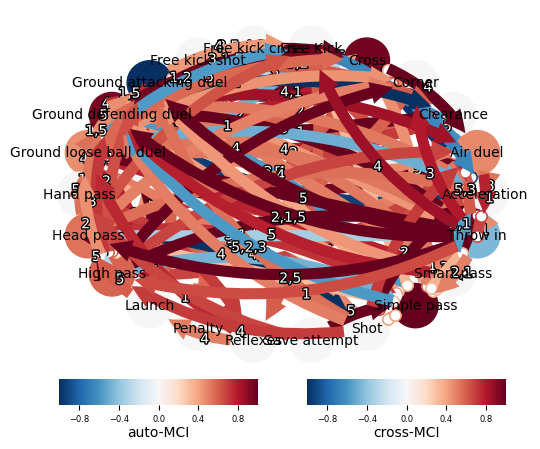

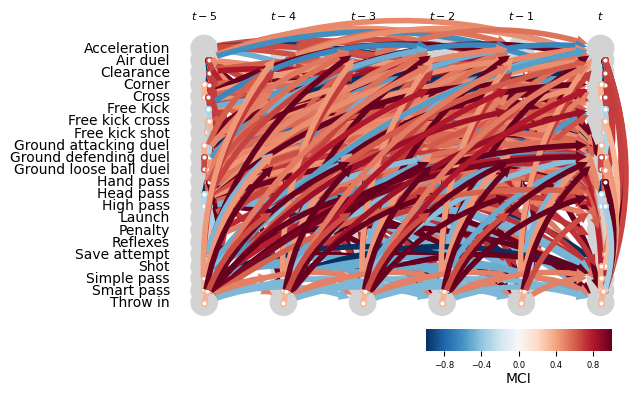

In [39]:
# Reconstruct graph and val_matrix
import tigramite.plotting as tp

def createEmptyMatrix(width, height, depth, initValue):
    return np.full((width, height, depth), initValue)


TAU_MAX = 5
match_folder = 'match_0'
graph = createEmptyMatrix(22, 22, TAU_MAX+1, '')
val_matrix = createEmptyMatrix(22, 22, TAU_MAX+1, 0.0)
actions = (pd.read_csv('fkeys/action.csv')['action']).tolist()
links = pd.read_csv('matches/match_0/aggregated_links.csv')
for index, row in links.iterrows():
    i = row['Variable i']
    j = row['Variable j']
    tau = int(row['Time lag of i'])
    link_type = row['Link type i --- j']
    link_value = row['Link value']
    graph[actions.index(i)][actions.index(j)][tau] = link_type
    val_matrix[actions.index(i)][actions.index(j)][tau] = link_value
    val_matrix[actions.index(j)][actions.index(i)][tau] = link_value
    
tp.plot_graph(
    val_matrix=val_matrix,
    graph=graph,
    var_names=actions,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False,
    save_name=f'matches/{match_folder}/graph.png'
)

tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=val_matrix,
    graph=graph,
    var_names=actions,
    link_colorbar_label='MCI',
    save_name=f'matches/{match_folder}/time_series_graph.png'
)